In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os
import math


### Carga de datos

In [27]:

#TODO Introducir el dataset con el que se vaya a trabajar
station = 'prat'
input_path = f'{station}_prec.csv'


df = pd.read_csv(f'./data/precipitation_data/{input_path}', parse_dates=['date'])
cols = [col for col in df.columns]

for col in df.columns:
    if col != 'date':  
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6713 entries, 0 to 6712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6713 non-null   datetime64[ns]
 1   prec    6572 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 105.0 KB


In [28]:

# Asegurarte de que la columna de fecha sea un tipo datetime
df["date"] = pd.to_datetime(df["date"])

# Crear un rango de fechas cada 3 horas
fecha_completa = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="6H")

# Crear un nuevo DataFrame con todas las fechas del rango
df_completo = pd.DataFrame({"date": fecha_completa})

# Combinar con el DataFrame original, alineando por la columna fecha
df_completo = df_completo.merge(df, on="date", how="left")

df = df_completo

df.isnull().sum()

date      0
prec    141
dtype: int64

### Ventana móvil

Ventana móvil con 2 fases.
1. Marca la "frontera" de los periodos válidos mirando hacia atrás. Marcará un 1 si el periodo de 365 días anterior es válido.
2. Refrescar el periodo de 365 días anterior a cada "flag" que tenga un 1, para marcar que el periodo ya es válido.

In [29]:

window_size = 365 * 4  
nulls_tolerance = 15 * 4 
value_counts = pd.DataFrame()

#Nos saltamos la columna de fecha e identificacion de la base
for col in df.columns:
    if df[col].dtype != np.float64 and df[col].dtype != np.int64:        
        print(f'{col} is not a number')
        continue
    print(f'{col} is a number')
    df[f'{col}_{station}'] = df[col].rolling(window=window_size, min_periods=1).apply(
        lambda x: 0 if x.isnull().sum() > nulls_tolerance or len(x) < window_size else 1
    )
    df[f'{col}_{station}'] = df[f'{col}_{station}'].replace({np.nan: 0})

    df[f'{col}_{station}'] = df[f'{col}_{station}'].astype(np.int8)

    value_counts[col] = df[f'{col}_{station}'].value_counts().reindex([0, 1], fill_value=0)
    print(value_counts[col])


date is not a number
prec is a number
prec_prat
0    2928
1    3785
Name: prec, dtype: int64


### Recalificación de flags

In [30]:
for col in df.columns:
    referenced_col = col.split('_')[0]
    if col.endswith(station):        
        print(f'{col} referenciando {referenced_col} va a ser reasignada ')
        for i in range(len(df[col])):
            if df.iloc[i, df.columns.get_loc(col)] == 1:  # Acceder al valor de la columna con iloc
                start_idx = max(0, i - window_size + 1)  
                
                # Buscar el primer índice no nulo en referenced_col dentro de la ventana
                for j in range(start_idx, i + 1):
                    if not pd.isna(df.iloc[j, df.columns.get_loc(referenced_col)]):
                        print(f'Columna {col} va a ser recalificada desde el índice {j} hasta {i}')
                        df.iloc[j:i+1, df.columns.get_loc(col)] = 1  # Recalificar desde el primer índice no nulo hasta el índice actual
                        break  # Terminar la búsqueda una vez encontrado el primer valor no nulo
    else:
        print(f'{col} NO va a ser reasignada ---> ')

date NO va a ser reasignada ---> 
prec NO va a ser reasignada ---> 
prec_prat referenciando prec va a ser reasignada 
Columna prec_prat va a ser recalificada desde el índice 2 hasta 1461
Columna prec_prat va a ser recalificada desde el índice 3 hasta 1462
Columna prec_prat va a ser recalificada desde el índice 4 hasta 1463
Columna prec_prat va a ser recalificada desde el índice 5 hasta 1464
Columna prec_prat va a ser recalificada desde el índice 7 hasta 1465
Columna prec_prat va a ser recalificada desde el índice 7 hasta 1466
Columna prec_prat va a ser recalificada desde el índice 8 hasta 1467
Columna prec_prat va a ser recalificada desde el índice 9 hasta 1468
Columna prec_prat va a ser recalificada desde el índice 10 hasta 1469
Columna prec_prat va a ser recalificada desde el índice 11 hasta 1470
Columna prec_prat va a ser recalificada desde el índice 12 hasta 1471
Columna prec_prat va a ser recalificada desde el índice 13 hasta 1472
Columna prec_prat va a ser recalificada desde el í

In [31]:
# Exportación

df.to_csv(f'./data/flagged/{station}_flagged_prec.csv', index=False)

### Visualización de los datos

Obteniendo gráficas generales
Graficar prec en el primer eje Y (ax)


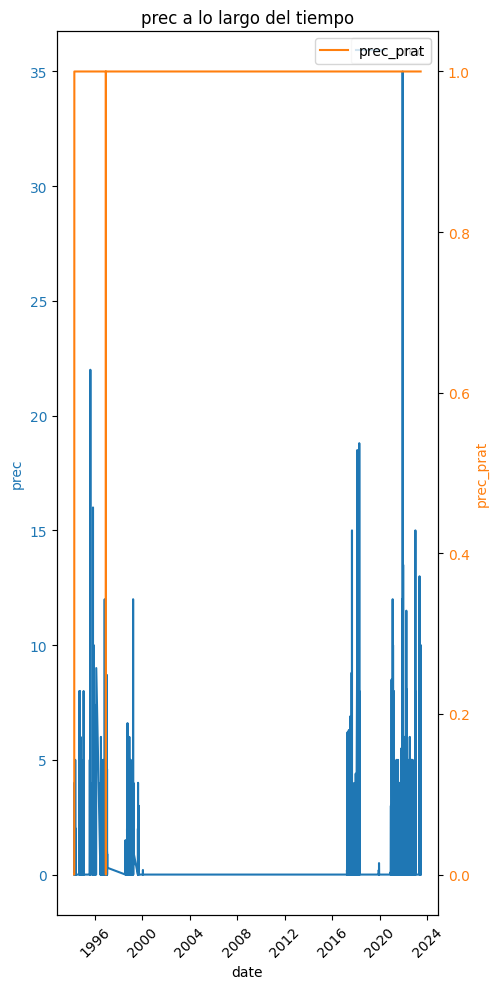

In [32]:
df['date'] = pd.to_datetime(df['date'])
print ('Obteniendo gráficas generales')
num_cols = 1
num_rows = 1

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(18, 10))  # Ajusta el tamaño de la figura según el número de filas


# Aplanar el array de ejes para poder iterar sobre él
axes = axes.flatten()

# Iterar sobre las columnas (excluyendo 'fhora') y generar gráficos
for ax, col in zip(axes, df.columns.drop('date')):
    station_col = f'{col}_{station}'  # Columna con el nombre de la estación

    if station_col in df.columns:  # Verificar si la columna _station existe
        print(f'Graficar {col} en el primer eje Y (ax)')
        
        # Primer eje Y para la columna principal
        color = 'tab:blue'
        ax.set_ylabel(col, color=color)
        sns.lineplot(x=df['date'], y=df[col], ax=ax, color=color, label=col)
        ax.tick_params(axis='y', labelcolor=color)
        ax.set_title(f'{col} a lo largo del tiempo')

        # Segundo eje Y para la columna _station
        ax2 = ax.twinx()  
        color = 'tab:orange'
        ax2.set_ylabel(station_col, color=color)
        sns.lineplot(x=df['date'], y=df[station_col], ax=ax2, color=color, label=station_col)
        ax2.tick_params(axis='y', labelcolor=color)

        # Rotar las etiquetas del eje X para mejor legibilidad
        ax.tick_params(axis='x', rotation=45)
        
# Eliminar los ejes sobrantes si el número de columnas no es múltiplo de 6
for i in range(num_cols * num_rows, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [26]:
df['hr'].iloc[5000:5050].head(50)

5000     87.0
5001     88.0
5002     87.0
5003     91.0
5004     80.0
5005     80.0
5006     68.0
5007     84.0
5008     79.0
5009     91.0
5010     93.0
5011     90.0
5012     88.0
5013     89.0
5014     87.0
5015     82.0
5016     88.0
5017     78.0
5018     84.0
5019     86.0
5020     95.0
5021      NaN
5022      NaN
5023      NaN
5024    100.0
5025     88.0
5026     88.0
5027     88.0
5028     88.0
5029     98.0
5030    100.0
5031    100.0
5032     92.0
5033     95.0
5034     94.0
5035    100.0
5036    100.0
5037    100.0
5038     96.0
5039     94.0
5040      NaN
5041      NaN
5042      NaN
5043      NaN
5044      NaN
5045      NaN
5046      NaN
5047      NaN
5048      NaN
5049      NaN
Name: hr, dtype: float64

### Gráfica individual

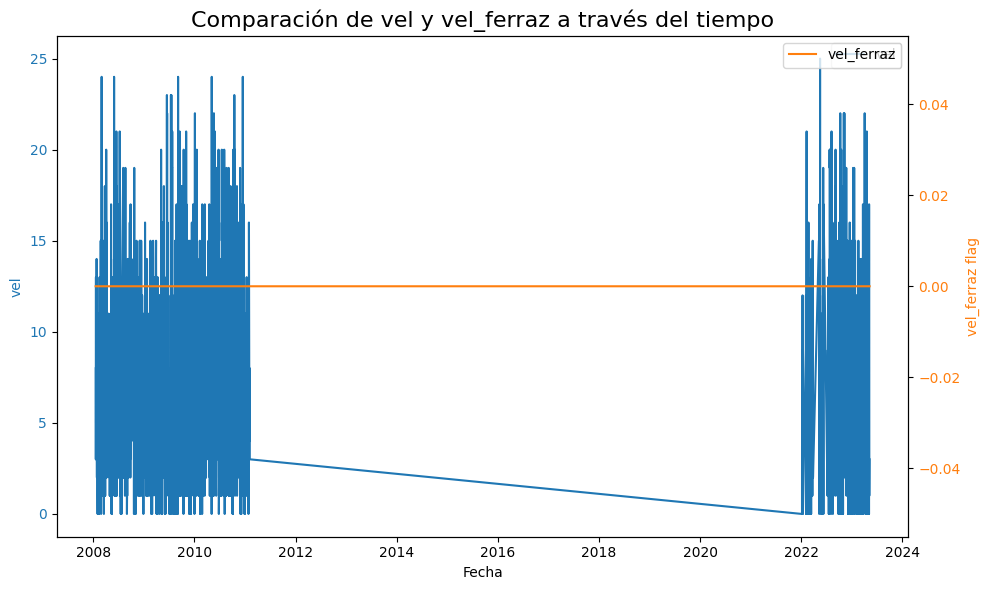

In [10]:

target= 'vel'


# Asegurarse de que 'date' está en formato datetime
df['date'] = pd.to_datetime(df['date'])

# Crear la figura y los dos ejes Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar df['hr'] en el primer eje Y (ax1)
color = 'tab:blue'
ax1.set_xlabel('Fecha')
ax1.set_ylabel(target, color=color)
sns.lineplot(x=df['date'], y=df[target], ax=ax1, color=color, label=target)
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje Y que comparta el eje X
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel(f'{target}_{station} flag', color=color)
sns.lineplot(x=df['date'], y=df[f'{target}_{station}'], ax=ax2, color=color, label=f'{target}_{station}')
ax2.tick_params(axis='y', labelcolor=color)

# Añadir título
plt.title(f'Comparación de {target} y {target}_{station} a través del tiempo', fontsize=16)

# Rotar las etiquetas del eje X para mejor legibilidad
plt.xticks(rotation=45)

# Ajustar el diseño para evitar superposición de elementos
plt.tight_layout()

# Mostrar la gráfica
plt.show()

### Generación de Heatmap

C:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Temp\ipykernel_14648\2938838878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flags['date'] = df['date']


5 2
hr_ferraz procede al mapa de calor
prec_ferraz procede al mapa de calor
pres_ferraz procede al mapa de calor
temp_ferraz procede al mapa de calor
dir_ferraz procede al mapa de calor
vel_ferraz procede al mapa de calor


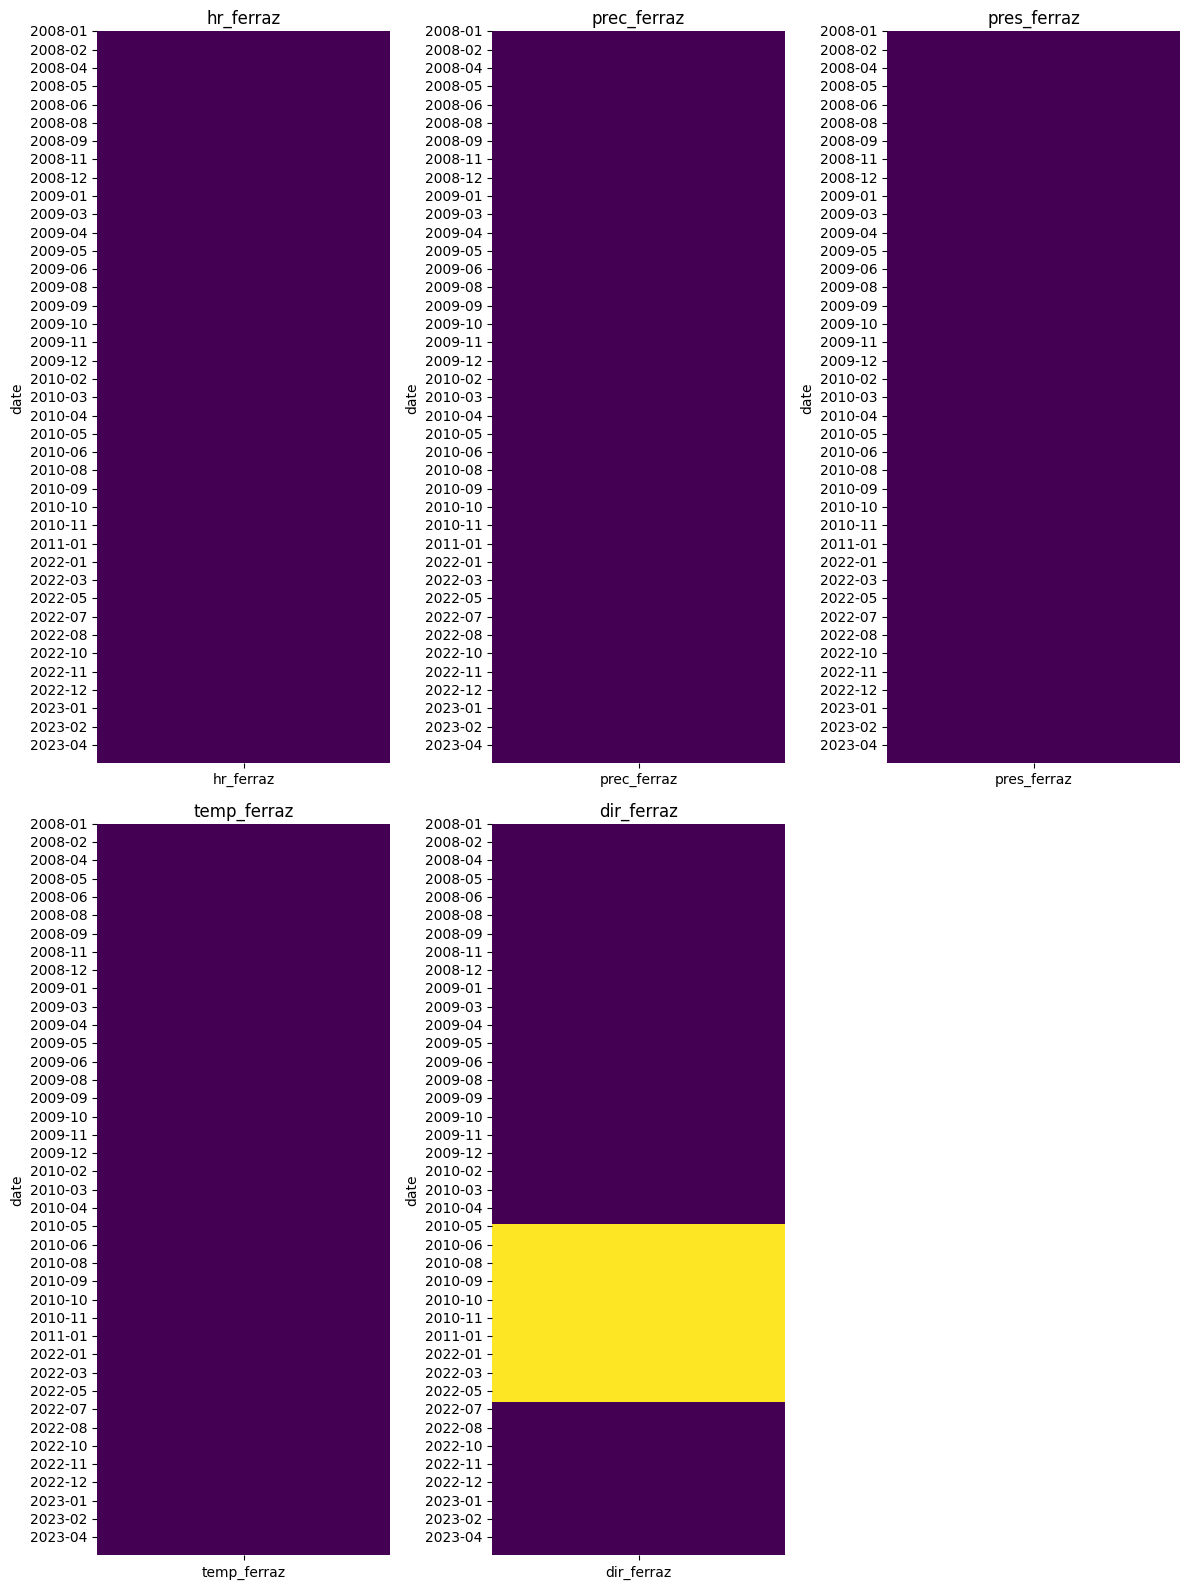

,date,hr,prec,pres,temp,dir,vel,hr_ferraz,prec_ferraz,pres_ferraz,temp_ferraz,dir_ferraz,vel_ferraz
0,2008-01-18 00:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0
1,2008-01-18 01:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0
2,2008-01-18 02:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0
3,2008-01-18 03:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0
4,2008-01-18 04:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0


In [15]:

df_flags = df[[col for col in df.columns if station in col]]
df_flags['date'] = df['date']

df_flags.set_index('date', inplace=True)
df_flags.index = pd.to_datetime(df_flags.index)
df_flags.index = df_flags.index.to_period('M') 

num_cols = len(df_flags.columns)-1

num_rows = math.ceil(num_cols / 3)  
print(num_cols, num_rows)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(12, 8 * num_rows))  # Ajusta el tamaño de la figura según el número de filas

# Aplanar el array de ejes para poder iterar sobre él
axes = axes.flatten()

# Iterar sobre las columnas y generar gráficos
for ax, col in zip(axes, df_flags.columns):
    if col != 'date':
        print(f'{col} procede al mapa de calor')
        sns.heatmap(df_flags[[col]], cbar=False, cmap='viridis', ax=ax)
        ax.set_title(col)
    

# Eliminar los ejes sobrantes si el número de columnas no es múltiplo de 3
if num_cols % 3:
    for ax in axes[num_cols:]:
        ax.remove()

plt.tight_layout()
plt.savefig(f'resource/heatmap_{station}_window.png')
plt.show()

df.head()

In [41]:
df_seleccion_periodo = df[['gdc_ts', 'ts']].loc['2015-01-01':'2015-03-01']
df_seleccion_periodo.to_csv('periodo_seleccionado.csv')

### Código para examinar una sola columna de forma individual

In [5]:
df_2006 = pd.read_json(f'data_{station}/{station}_2006.json')
df_2006.head()

,identificacion,nombre,latitud,longitud,altitud,srs,alt_nieve,ddd,dddstd,dddx,...,global,ir_solar,neta,par,tcielo,ttierra,uvab,uvb,uvi,qdato
0,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,334,0,0,...,0,0,0,0,0,0,0,0,0,0
1,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,333,0,0,...,0,0,0,0,0,0,0,0,0,0
2,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,340,0,0,...,0,0,0,0,0,0,0,0,0,0
3,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,342,0,0,...,0,0,0,0,0,0,0,0,0,0
4,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,343,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
target = 'lluv'

plt.figure(figsize=(10, 6))
plt.plot(df_2006['fhora'], df_2006[f'{target}'])
plt.xlabel('fhora')
plt.ylabel(f'{target}')
plt.title(f'{target} a lo largo de fhora')
plt.show()